In [ ]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from deepxde.backend import tf

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



$u_t + 3 u_x = x t, x \in \mathbb{R}, t \geq 0$ \\
$u(x, 0) = e^{-x^2}$

In [ ]:
def pde(x, u):
  du_t = dde.gradients.jacobian(u, x, i=0, j=1)
  du_x = dde.gradients.jacobian(u, x, i=0, j=0)
  return du_t + 3 * du_x - x[:, 1:2] * x[:, 0:1]

def initial_condition(x):
  return np.exp(-(x[:, 0:1])**2)

# Without hard constraints

PINN with soft constraints, using 1000 points inside the domain, 200 points in the spatial boundary and 200 points for the initial condition.

In [ ]:
geom = dde.geometry.Interval(-4, 4)
time = dde.geometry.timedomain.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, time)

bc = dde.icbc.IC(geomtime, initial_condition, lambda x, on_initial: np.isclose(x[1], 0))

data = dde.data.TimePDE(geomtime, pde, [bc], num_domain=1000, num_boundary=200, num_initial=200, num_test=320)

Using a feedforward neural network with 3 hidden layers of 50 neurons, with tanh activation function. The model is trained with 30000 iterations of the Adam optimizer and some iterations of L-BFGS

Compiling model...
Building feed-forward neural network...
'build' took 0.053410 s

'compile' took 0.386848 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.26e+00, 2.31e-01]    [2.43e+00, 2.31e-01]    []  
1000      [1.41e-03, 2.45e-03]    [1.85e-03, 2.45e-03]    []  
2000      [7.17e-04, 9.88e-04]    [8.35e-04, 9.88e-04]    []  
3000      [1.87e-04, 2.13e-04]    [2.90e-04, 2.13e-04]    []  
4000      [1.16e-04, 8.08e-05]    [1.99e-04, 8.08e-05]    []  
5000      [6.03e-04, 3.29e-04]    [5.85e-04, 3.29e-04]    []  
6000      [7.20e-05, 2.75e-05]    [1.05e-04, 2.75e-05]    []  
7000      [1.87e-03, 9.41e-04]    [1.82e-03, 9.41e-04]    []  
8000      [4.86e-05, 1.09e-05]    [6.90e-05, 1.09e-05]    []  
9000      [4.08e-05, 7.57e-06]    [5.79e-05, 7.57e-06]    []  
10000     [3.18e-05, 5.78e-06]    [4.57e-05, 5.78e-06]    []  
11000     [2.51e-05, 7.16e-06]    [3.62e-05, 7.16e-06]    []  
12000     [2.01e-0

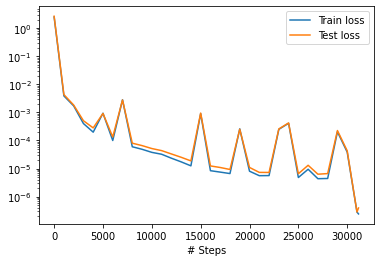

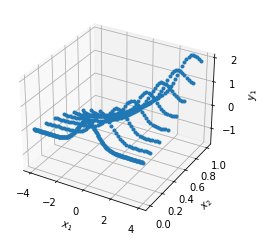

In [ ]:
net = dde.maps.FNN([2] + [50] * 3 + [1], 'tanh', 'Glorot uniform')

model = dde.Model(data, net)

model.compile('adam', lr=0.001)
model.train(iterations=30000)
model.compile('L-BFGS')
loss_history, train_state = model.train()
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

Plotting the prediction of the neural network

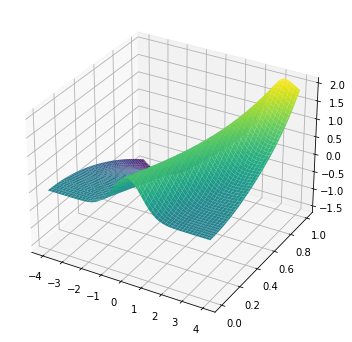

In [ ]:
x = np.linspace(-4, 4, 100)
t = np.linspace(0, 1, 100)
x, t = np.meshgrid(x, t)
inputs = np.column_stack((x.flatten(), t.flatten()))
predictions = model.predict(inputs)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(x, t, predictions.reshape(100, 100), cmap='viridis', edgecolor='none')

Plotting the analytical solution of the PDE:
$u(x, t) = e^{-(x - 3 t)^2} + \frac{t^2}{2} (x - t)$

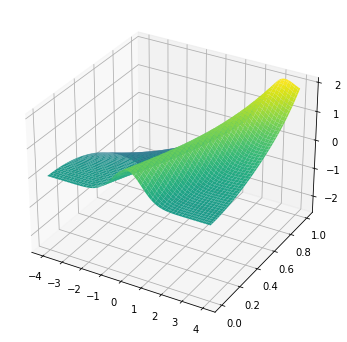

In [ ]:
true_values = np.exp(-(x - 3*t)**2) + ((t**2) / 2) * (x - t)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(x, t, true_values, cmap='viridis', edgecolor='none')

# With hard constraints

PINN with hard constraints: the initial condition is enforce by applying the following output transformation

$\hat{u}(x, t) = t u_{NN}(x, t) + e^{-x^2}$

where $\hat{u}$ is the transformed output and $u_{NN}$ is the output of the neural network. The model is trained the same of the previous case (3 hidden layers with 50 neurons each) and is trained using the same number of points and the same optimizers.

In [ ]:
geom = dde.geometry.Interval(-4, 4)
time = dde.geometry.timedomain.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, time)

data = dde.data.TimePDE(geomtime, pde, [], num_domain=1000, num_boundary=200, num_initial=200, num_test=320)

Compiling model...
Building feed-forward neural network...
'build' took 0.062000 s

'compile' took 0.411394 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric
0         [2.96e+00]    [3.49e+00]    []  
1000      [3.87e-03]    [3.08e-03]    []  
2000      [1.17e-03]    [9.16e-04]    []  
3000      [5.79e-04]    [5.37e-04]    []  
4000      [7.23e-04]    [7.40e-04]    []  
5000      [2.35e-04]    [2.67e-04]    []  
6000      [1.77e-04]    [2.29e-04]    []  
7000      [1.39e-04]    [1.98e-04]    []  
8000      [1.08e-04]    [1.65e-04]    []  
9000      [8.57e-05]    [1.39e-04]    []  
10000     [6.93e-05]    [1.16e-04]    []  
11000     [5.71e-05]    [9.78e-05]    []  
12000     [5.49e-05]    [8.83e-05]    []  
13000     [6.88e-05]    [9.67e-05]    []  
14000     [3.55e-05]    [6.35e-05]    []  
15000     [3.82e-05]    [5.98e-05]    []  
16000     [2.69e-05]    [4.76e-05]    []  
17000     [2.41e-05]    [4.17e-05]    []  
18000     [8.12e-05]

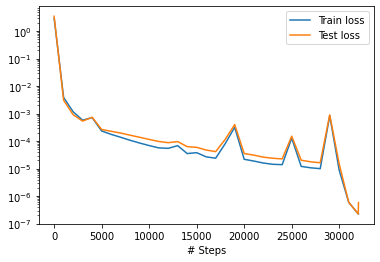

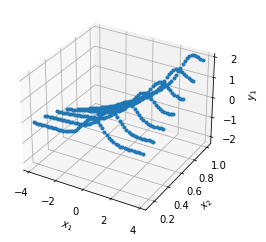

In [ ]:
net = dde.maps.FNN([2] + [50] * 3 + [1], 'tanh', 'Glorot uniform')

def transform(x, y):
  t = x[:, 1:2]
  x_ = x[:, 0:1]
  return t * y + tf.exp(-(x_**2))

net.apply_output_transform(transform)

model_hard = dde.Model(data, net)

model_hard.compile('adam', lr=0.001)
model_hard.train(iterations=30000)
model_hard.compile('L-BFGS')
loss_history, train_state = model_hard.train()
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

Plotting the prediction of the PINN with hard constraints

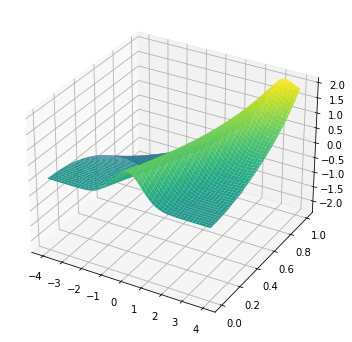

In [ ]:
x = np.linspace(-4, 4, 100)
t = np.linspace(0, 1, 100)
x, t = np.meshgrid(x, t)
inputs = np.column_stack((x.flatten(), t.flatten()))
predictions_hard = model_hard.predict(inputs)

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.plot_surface(x, t, predictions_hard.reshape(100, 100), cmap='viridis', edgecolor='none')

Comparing the errors in the predictions from in the two situations

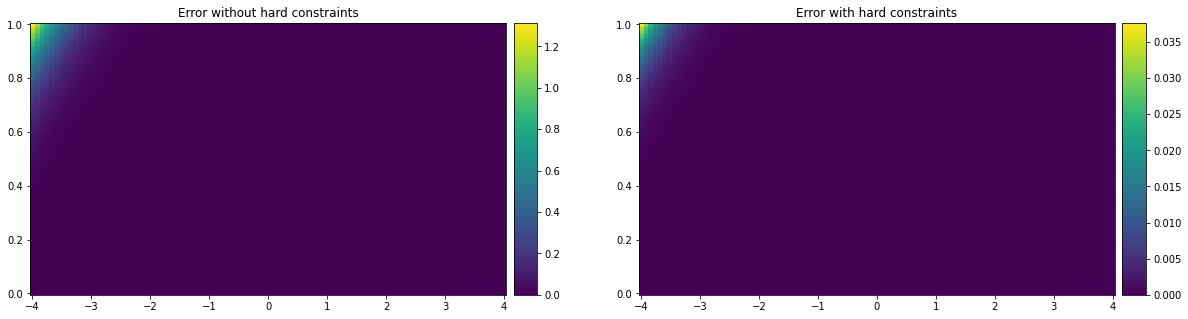

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

error_hard = (true_values - predictions_hard.reshape(100, 100))**2
error = (true_values - predictions.reshape(100, 100))**2

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

plt1 = axs[0].pcolormesh(x, t, error, cmap='viridis')
axs[0].set_title('Error without hard constraints')
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plt1, cax=cax1, orientation='vertical');

plt2 = axs[1].pcolormesh(x, t, error_hard, cmap='viridis')
axs[1].set_title('Error with hard constraints')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(plt2, cax=cax2, orientation='vertical');

plt.show()